# Project 2 - Analyzing Titanic Data
# by Dogan Askan 

## Part 1 - First Glance

Metadata can be found at https://www.kaggle.com/c/titanic/data

In [16]:
#Necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.special import stdtr
import scipy.stats as stats
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from scipy.stats import chi2_contingency

After necessary libraries are loaded, an initial look can be taken to the data

In [5]:
#load the data
filename = 'titanic_data.csv'
raw_titanic_df = pd.read_csv(filename)
raw_titanic_df.head() #the first glance

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex  Age  SibSp  \
0                            Braund, Mr. Owen Harris    male   22      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   38      1   
2                             Heikkinen, Miss. Laina  female   26      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   35      1   
4                           Allen, Mr. William Henry    male   35      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

Below are the some descriptive statistics about the data. 

In [6]:
raw_titanic_df.groupby(['Pclass','Sex']).mean() #means grouped by "Age" and "Sex"

PassengerId  Survived        Age     SibSp     Parch  \
Pclass Sex                                                            
1      female   469.212766  0.968085  34.611765  0.553191  0.457447   
       male     455.729508  0.368852  41.281386  0.311475  0.278689   
2      female   443.105263  0.921053  28.722973  0.486842  0.605263   
       male     447.962963  0.157407  30.740707  0.342593  0.222222   
3      female   399.729167  0.500000  21.750000  0.895833  0.798611   
       male     455.515850  0.135447  26.507589  0.498559  0.224784   

                     Fare  
Pclass Sex                 
1      female  106.125798  
       male     67.226127  
2      female   21.970121  
       male     19.741782  
3      female   16.118810  
       male     12.661633

In [7]:
raw_titanic_df.describe() #Descriptive statiscits about the data

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

Since *Age* count is less than 891, there are some missing values. 

There may also be missing values in other columns.  
Below code reveals the missing ones. It seems that only *Cabin* has some missing values in addition to *Age*.

In [8]:
raw_titanic_df.info() #to check all missing values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


## Part 2 - Data Wrangling
To handling *Age* missing values, we can assign mean values grouped by *Pclass* and *Sex* in order to be more accurate.

In [9]:
#Handling missing "Age" values
row_iterator = raw_titanic_df.iterrows() #start iteration
for i, row in row_iterator:
    if np.isnan(row['Age']): #check if NaN
        pclass=row['Pclass']
        sex=row['Sex']
        meanage=raw_titanic_df[(raw_titanic_df['Pclass']==pclass) & (raw_titanic_df['Sex']==sex)].mean()['Age'] #mean grouped by Pclass and Sex
        raw_titanic_df.set_value(i,'Age',int(meanage)) #change the value

New features are also needed to add to use anwering the questions,
<li>*SibSp_Parch_sum* for total amount of relatives abroad
<li>*Age_Bucket* for grouping ages
<li>*Relative_Bucket* for total amount of relatives abroad

In [10]:
#SibSp_Parch_sum for total amount of relatives abroad
raw_titanic_df['SibSp_Parch_sum'] = pd.Series(raw_titanic_df['SibSp']+raw_titanic_df['Parch'],
                                              index=raw_titanic_df.index) 

#Age_Bucket for grouping ages
row_iterator = raw_titanic_df.iterrows() #start iteration
for i, row in row_iterator:
    if row['Age']>=0 and row['Age']<10:
        raw_titanic_df.set_value(i,'Age_Bucket','0-9') #change the value
    elif row['Age']>=10 and row['Age']<20:
        raw_titanic_df.set_value(i,'Age_Bucket','10-19') #change the value
    elif row['Age']>=20 and row['Age']<30:
        raw_titanic_df.set_value(i,'Age_Bucket','20-29') #change the value
    elif row['Age']>=30 and row['Age']<40:
        raw_titanic_df.set_value(i,'Age_Bucket','30-39') #change the value
    elif row['Age']>=40 and row['Age']<50:
        raw_titanic_df.set_value(i,'Age_Bucket','40-49') #change the value
    elif row['Age']>=50 and row['Age']<60:
        raw_titanic_df.set_value(i,'Age_Bucket','50-59') #change the value
    elif row['Age']>=60 and row['Age']<70:
        raw_titanic_df.set_value(i,'Age_Bucket','60-69') #change the value
    elif row['Age']>=70:
        raw_titanic_df.set_value(i,'Age_Bucket','70+') #change the value

#Relative_Bucket for total amount of relatives abroad
row_iterator = raw_titanic_df.iterrows() #start iteration
for i, row in row_iterator:
    if row['SibSp_Parch_sum']==1:
        raw_titanic_df.set_value(i,'Relative_Bucket','One Relative') #change the value
    elif row['SibSp_Parch_sum']==0:
        raw_titanic_df.set_value(i,'Relative_Bucket','No Relative') #change the value
    elif row['SibSp_Parch_sum']>1:
        raw_titanic_df.set_value(i,'Relative_Bucket','More Than One Relative') #change the value

Now, as the last phase of data wrangling, data types can be redefined if necessary.

In [11]:
raw_titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 15 columns):
PassengerId        891 non-null int64
Survived           891 non-null int64
Pclass             891 non-null int64
Name               891 non-null object
Sex                891 non-null object
Age                891 non-null float64
SibSp              891 non-null int64
Parch              891 non-null int64
Ticket             891 non-null object
Fare               891 non-null float64
Cabin              204 non-null object
Embarked           889 non-null object
SibSp_Parch_sum    891 non-null int64
Age_Bucket         891 non-null object
Relative_Bucket    891 non-null object
dtypes: float64(2), int64(6), object(7)
memory usage: 111.4+ KB


*PassengerId* and *Pclass* are non-additive attributes, so these need to be string.

In [12]:
titanic_df=raw_titanic_df.copy() #the data is ready to be analyzed as "titanic_df"
titanic_df['PassengerId'] = titanic_df['PassengerId'].astype(str)
titanic_df['Pclass'] = titanic_df['Pclass'].astype(str)

In [13]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 15 columns):
PassengerId        891 non-null object
Survived           891 non-null int64
Pclass             891 non-null object
Name               891 non-null object
Sex                891 non-null object
Age                891 non-null float64
SibSp              891 non-null int64
Parch              891 non-null int64
Ticket             891 non-null object
Fare               891 non-null float64
Cabin              204 non-null object
Embarked           889 non-null object
SibSp_Parch_sum    891 non-null int64
Age_Bucket         891 non-null object
Relative_Bucket    891 non-null object
dtypes: float64(2), int64(4), object(9)
memory usage: 111.4+ KB


Now the data is ready to be analyzed.

## Part 3 - Questions to be Analyzed
1- Is there any effect of gender on survival ratio?  
2- Is there any effect of age on survival ratio?  
3- Is there any effect of passenger class on survival ratio?    
4- Which group's fare is more varied in Titanic? Groups are constructed per passenger class per gender.   
5- Is there any effect of passenger class on abroad relative number in Titanic passengers?  
6- Is there any effect of abroad relative number on survival ratio?   

For the question 1, the hypothesis are,  
H0: Survival ratio of men = Survival ratio of women  
Ha: not H0

In [14]:
men_survival=titanic_df[(titanic_df['Sex']=='male')]['Survived']
women_survival=titanic_df[(titanic_df['Sex']=='female')]['Survived']
print "Survival ratio of men: " + str(men_survival.mean())
print "Survival ratio of women: " + str(women_survival.mean())

#bar plot
y=[men_survival.mean(),women_survival.mean()]
labels=['Men','Women']
x = np.arange(len(labels))
plt.bar(x, y, align='center', alpha=0.5)
plt.xticks(x, labels)
plt.ylabel('Survival ratio')
plt.title('Survival ratio comparison by gender') 
plt.show()

Survival ratio of men: 0.188908145581
Survival ratio of women: 0.742038216561


And, Chi-Squared is perfomerd below,

In [19]:
# Chi-Squared Tests
# Sex to Survivability
pivot = pd.pivot_table(data = titanic_df[['Survived', 'Sex']], index = 'Survived', columns = ['Sex'], aggfunc = len)
pivot
print pivot,"\n"

chi2, p_value, dof, expected = chi2_contingency(pivot)
print "Results of Chi-Squared test on Sex to Survival."
print "Does Sex have a significant effect on Survival?"
print "Chi-Squared Score = " + str(chi2)
print "Pvalue = " + str(p_value)
print "Degrees of Freedom = " + str(dof)

Sex       female  male
Survived              
0             81   468
1            233   109 

Results of Chi-Squared test on Sex to Survival.
Does Sex have a significant effect on Survival?
Chi-Squared Score = 260.717020167
Pvalue = 1.19735706278e-58
Degrees of Freedom = 1


And, chiSquared-critical at alpha=.05 is about 3.841,  
Since, chiSquared-statistic > chiSquared-critical at p-value < .05, null hypothesis can be rejected.  
As a result, there is a statistically significant evidence that gender had an effect on survival. Women survival ratio is higher.

For the question 2, the hypothesis are,  
H0: Age had no effect on survival ratio in Titanic disaster.  
Ha: not H0

In [415]:
#Plot of Age Bucket
age_bucket_count=titanic_df.groupby(['Age_Bucket']).count()['Survived']
print age_bucket_count
#bar plot
age_bucket_count.plot.bar()
plt.ylabel('Count')
plt.title('Age Bucket Count')

Age_Bucket
0-9       62
10-19    102
20-29    358
30-39    185
40-49    110
50-59     48
60-69     19
70+        7
Name: Survived, dtype: int64


Age_Bucket
0-9      0.612903
10-19    0.401961
20-29    0.315642
30-39    0.454054
40-49    0.354545
50-59    0.416667
60-69    0.315789
70+      0.142857
Name: Survived, dtype: float64


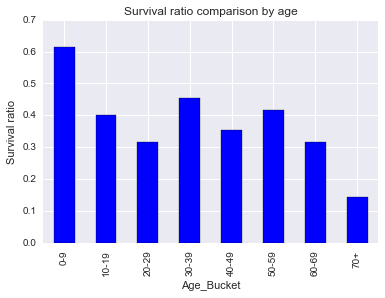

In [414]:
age_survival_ratio=titanic_df.groupby(['Age_Bucket']).mean()['Survived']
print age_survival_ratio
#bar plot
age_survival_ratio.plot.bar()
plt.ylabel('Survival ratio')
plt.title('Survival ratio comparison by age') 

According to above values, it looks children had more chances to survive.  
Let's look statistically as well.

In [20]:
# Chi-Squared Tests
# Age to Survivability
pivot = pd.pivot_table(data = titanic_df[['Survived', 'Age_Bucket']], index = 'Survived', columns = ['Age_Bucket'], aggfunc = len)
pivot
print pivot,"\n"

chi2, p_value, dof, expected = chi2_contingency(pivot)
print "Results of Chi-Squared test on Age to Survival."
print "Does Age have a significant effect on Survival?"
print "Chi-Squared Score = " + str(chi2)
print "Pvalue = " + str(p_value)
print "Degrees of Freedom = " + str(dof)

Age_Bucket  0-9  10-19  20-29  30-39  40-49  50-59  60-69  70+
Survived                                                      
0            24     61    245    101     71     28     13    6
1            38     41    113     84     39     20      6    1 

Results of Chi-Squared test on Age to Survival.
Does Age have a significant effect on Survival?
Chi-Squared Score = 27.5016813309
Pvalue = 0.000270619319672
Degrees of Freedom = 7


And, Chi-Squared-critical at alpha=.05 is about 14.067, since, Chi-Squared-statistic > Chi-Squared-critical at p-value < .05, null hypothesis can be rejected. There is a statistically significant evidence age buckets had different survival chances.

For the question 3, the hypothesis are,  
H0: Passenger class had no effect on survival ratio in Titanic disaster.  
Ha: not H0

Pclass
1    216
2    184
3    491
Name: Survived, dtype: int64


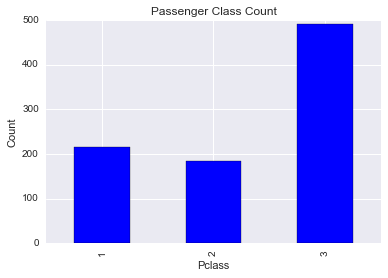

In [416]:
#Plot of Passenger Class
pclass_count=titanic_df.groupby(['Pclass']).count()['Survived']
print pclass_count
#bar plot
pclass_count.plot.bar()
plt.ylabel('Count')
plt.title('Passenger Class Count')

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


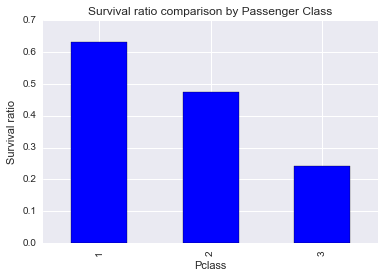

In [417]:
pclass_survival_ratio=titanic_df.groupby(['Pclass']).mean()['Survived']
print pclass_survival_ratio
#bar plot
pclass_survival_ratio.plot.bar()
plt.ylabel('Survival ratio')
plt.title('Survival ratio comparison by Passenger Class') 

According to above values, it looks better passenger class had more chances to survive.  
Let's look statistically as well.

In [25]:
# Chi-Squared Tests
# Pclass to Survivability
pivot = pd.pivot_table(data = titanic_df[['Survived', 'Pclass']], index = 'Survived', columns = ['Pclass'], aggfunc = len)
print pivot,"\n"

chi2, p_value, dof, expected = chi2_contingency(pivot)
print "Results of Chi-Squared test on Pclass to Survival."
print "Does Pclass have a significant effect on Survival?"
print "Chi-Squared Score = " + str(chi2)
print "Pvalue = " + str(p_value)
print "Degrees of Freedom = " + str(dof)

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119 

Results of Chi-Squared test on Pclass to Survival.
Does Pclass have a significant effect on Survival?
Chi-Squared Score = 102.888988757
Pvalue = 4.5492517113e-23
Degrees of Freedom = 2


And, Chi-Squared-critical at alpha=.05 is about 5.991, since, Chi-Squared-statistic > Chi-Squared-critical at p-value < .05, null hypothesis can be rejected. There is a statistically significant evidence passenger classes had different survival chances.

For question 4, some descriptive statistics can be utilized.

In [428]:
titanic_df.groupby(['Pclass','Sex'])['Fare'].describe()

Pclass  Sex          
1       female  count     94.000000
                mean     106.125798
                std       74.259988
                min       25.929200
                25%       57.244800
                50%       82.664550
                75%      134.500000
                max      512.329200
        male    count    122.000000
                mean      67.226127
                std       77.548021
                min        0.000000
                25%       27.728100
                50%       41.262500
                75%       78.459375
                max      512.329200
2       female  count     76.000000
                mean      21.970121
                std       10.891796
                min       10.500000
                25%       13.000000
                50%       22.000000
                75%       26.062500
                max       65.000000
        male    count    108.000000
                mean      19.741782
                std       14.922235
      

(0, 260)

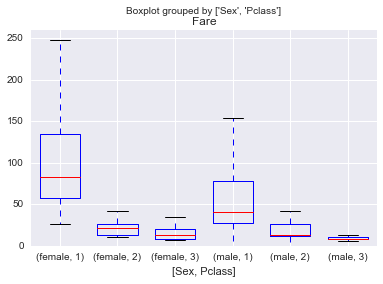

In [467]:
titanic_df.boxplot(column='Fare',by=['Sex','Pclass'], widths=0.7)
plt.ylim((0,260))

So, according to above visualization and values, fare range is the largest and vary most in first class, especially in women.

For the question 5, the hypothesis are,  
H0: Passenger class had no effect on abroad relative number.  
Ha: not H0

Mean relative number of Class 1: 0.773148148148
Mean relative number of Class 2: 0.782608695652
Mean relative number of Class 3: 1.00814663951


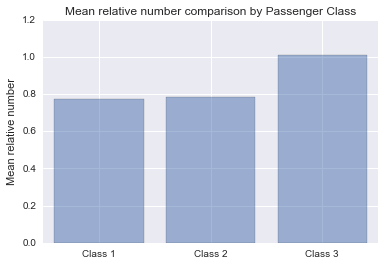

In [468]:
class1_relative=titanic_df[(titanic_df['Pclass']=='1')]['SibSp_Parch_sum']
class2_relative=titanic_df[(titanic_df['Pclass']=='2')]['SibSp_Parch_sum']
class3_relative=titanic_df[(titanic_df['Pclass']=='3')]['SibSp_Parch_sum']
print "Mean relative number of Class 1: " + str(class1_relative.mean())
print "Mean relative number of Class 2: " + str(class2_relative.mean())
print "Mean relative number of Class 3: " + str(class3_relative.mean())

#bar plot
y=[class1_relative.mean(),class2_relative.mean(),class3_relative.mean()]
labels=['Class 1','Class 2','Class 3']
x = np.arange(len(labels))
plt.bar(x, y, align='center', alpha=0.5)
plt.xticks(x, labels)
plt.ylabel('Mean relative number')
plt.title('Mean relative number comparison by Passenger Class') 
plt.show()

According to above values, it looks third class may have more relatives.  
Let's look statistically as well.

In [469]:
#df1=2, df2=888
stats.f_oneway(titanic_df[(titanic_df['Pclass']=='1')]['SibSp_Parch_sum'],
               titanic_df[(titanic_df['Pclass']=='2')]['SibSp_Parch_sum'],
               titanic_df[(titanic_df['Pclass']=='3')]['SibSp_Parch_sum'])

F_onewayResult(statistic=2.2603199692962921, pvalue=0.10491697132973478)

So, f-critical at alpha=.05 is about 2.9957, since, f-statistic < f-critical at p-value > .05, null hypothesis can be failed to reject. There is no statistically significant evidence that at least two passenger classes had different abroad relative number.

For the question 6, the hypothesis are,  
H0: Abroad relative number had no effect on survival ratio.  
Ha: not H0

Relative_Bucket
More Than One Relative    0.466321
No Relative               0.303538
One Relative              0.552795
Name: Survived, dtype: float64


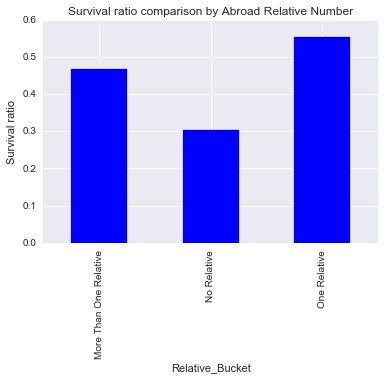

In [470]:
relative_survival_ratio=titanic_df.groupby(['Relative_Bucket']).mean()['Survived']
print relative_survival_ratio
#bar plot
relative_survival_ratio.plot.bar()
plt.ylabel('Survival ratio')
plt.title('Survival ratio comparison by Abroad Relative Number') 

According to above values, it looks abroad relative number may have some effect on survival.
Let's look statistically as well.

In [24]:
# Chi-Squared Tests
# Relative Number to Survivability
pivot = pd.pivot_table(data = titanic_df[['Survived', 'Relative_Bucket']], index = 'Survived', 
                       columns = ['Relative_Bucket'], aggfunc = len)
print pivot,"\n"

chi2, p_value, dof, expected = chi2_contingency(pivot)
print "Results of Chi-Squared test on Relative Number to Survival."
print "Does Relative Number have a significant effect on Survival?"
print "Chi-Squared Score = " + str(chi2)
print "Pvalue = " + str(p_value)
print "Degrees of Freedom = " + str(dof)

Relative_Bucket  More Than One Relative  No Relative  One Relative
Survived                                                          
0                                   103          374            72
1                                    90          163            89 

Results of Chi-Squared test on Relative Number to Survival.
Does Relative Number have a significant effect on Survival?
Chi-Squared Score = 39.6254046963
Pvalue = 2.48572281574e-09
Degrees of Freedom = 2


So, Chi-Squared-critical at alpha=.05 is about 5.991, since, Chi-Squared-statistic > Chi-Squared-critical at p-value < .05, null hypothesis can be rejected. There is a statistically significant evidence that relative buckets had effect on survival.